pvfactors: Jupyter notebook guide
============================

This Jupyter notebook demonstrates how to use the package for irradiance calculations.

<h3>Imports and settings</h3>

In [1]:
# Import external libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Settings
%matplotlib inline
np.set_printoptions(precision=3, linewidth=300)

## TL;DR

Given some timeseries inputs:

In [2]:
df_inputs = pd.DataFrame(
    {'solar_zenith': [20., 50.],
     'solar_azimuth': [110., 250.],
     'surface_tilt': [10., 20.],
     'surface_azimuth': [90., 270.],
     'dni': [1000., 900.],
     'dhi': [50., 100.],
     'albedo': [0.2, 0.2]}, 
    index=[datetime(2017, 8, 31, 11), datetime(2017, 8, 31, 15)]
)
df_inputs

,solar_zenith,solar_azimuth,surface_tilt,surface_azimuth,dni,dhi,albedo
2017-08-31 11:00:00,20.0,110.0,10.0,90.0,1000.0,50.0,0.2
2017-08-31 15:00:00,50.0,250.0,20.0,270.0,900.0,100.0,0.2


And some PV array parameters:

In [3]:
pvarray_parameters = {
    'n_pvrows': 3,            # number of pv rows
    'pvrow_height': 1,        # height of pvrows (measured at center / torque tube)
    'pvrow_width': 1,         # width of pvrows
    'axis_azimuth': 0.,       # azimuth angle of rotation axis
    'gcr': 0.4,               # ground coverage ratio
}

The user can quickly create a PV array with ``pvfactors``, and manipulate it with the engine

In [4]:
from pvfactors.geometry import OrderedPVArray
# Create PV array
pvarray = OrderedPVArray.init_from_dict(pvarray_parameters)

In [5]:
from pvfactors.engine import PVEngine
# Create engine
engine = PVEngine(pvarray)
# Fit engine to data
engine.fit(df_inputs.index, df_inputs.dni, df_inputs.dhi, 
           df_inputs.solar_zenith, df_inputs.solar_azimuth, 
           df_inputs.surface_tilt, df_inputs.surface_azimuth, 
           df_inputs.albedo)

The user can then plot the PV array geometry at any given time of the simulation:

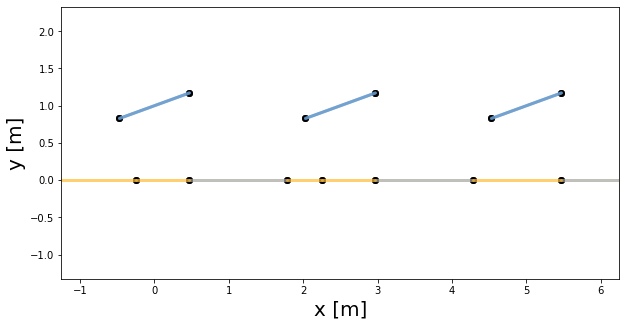

In [6]:
# Plot pvarray shapely geometries
f, ax = plt.subplots(figsize=(10, 5))
pvarray.plot_at_idx(1, ax)
plt.show()

It is then very easy to run simulations using the defined engine:

In [7]:
pvarray = engine.run_full_mode_timestep(1)

And inspect the results thanks to the simple geometry API

In [8]:
print("Incident irradiance on front surface of middle pv row: %.2f W/m2"
      % (pvarray.pvrows[1].front.get_param_weighted('qinc')))
print("Reflected irradiance on back surface of left pv row: %.2f W/m2"
      % (pvarray.pvrows[0].back.get_param_weighted('reflection')))
print("Isotropic irradiance on back surface of right pv row: %.2f W/m2"
      % (pvarray.pvrows[2].back.get_param_weighted('isotropic')))

Incident irradiance on front surface of middle pv row: 886.38 W/m2
Reflected irradiance on back surface of left pv row: 86.40 W/m2
Isotropic irradiance on back surface of right pv row: 1.85 W/m2


The users can also run simulations for all provided timestamps, and obtain a "report" that will look like whatever the users want, and which can rely on the simple API shown above.
The two options to run the simulations are:

- fast mode: almost instantaneous results for back side irradiance calculations, but simple reflection assumptions

In [9]:
# Create a function that will build a report
def fn_report(pvarray): return {'qinc_back': pvarray.ts_pvrows[1].back.get_param_weighted('qinc')}

# Run fast mode simulation
report = engine.run_fast_mode(fn_build_report=fn_report, pvrow_index=1)

# Print results (report is defined by report function passed by user)
df_report = pd.DataFrame(report, index=df_inputs.index)
df_report

,qinc_back
2017-08-31 11:00:00,110.586509
2017-08-31 15:00:00,86.943571


- full mode: which calculates the equilibrium of reflections for all timestamps and all surfaces

In [10]:
# Create a function that will build a report
from pvfactors.report import example_fn_build_report

# Run full mode simulation
report = engine.run_full_mode(fn_build_report=example_fn_build_report)

# Print results (report is defined by report function passed by user)
df_report = pd.DataFrame(report, index=df_inputs.index)
df_report

100%|██████████| 2/2 [00:00<00:00, 51.08it/s]


,qinc_front,qinc_back,iso_front,iso_back
2017-08-31 11:00:00,1034.967753,106.627832,20.848345,0.115792
2017-08-31 15:00:00,886.376819,79.668878,54.995702,1.255482
